<a href="https://colab.research.google.com/github/deagwon97/ct/blob/main/ct_unet_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output

In [2]:

!pip install pydicom
!pip install catalyst
!pip install segmentation_models_pytorch
!pip install albumentations==0.3.2
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir # albu.lambda 지원을 위해 설치
clear_output()

In [3]:
import cv2
import collections
import time 
from tqdm import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import copy
import torch
import numpy as np # linear algebra
import cupy as cp 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pydicom
import time
import sys
sys.path.append('/content/drive/My Drive/ct')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import torch as AT
from albumentations import Compose,Resize,OneOf,RandomBrightness,RandomContrast,Normalize,HorizontalFlip,Blur,ElasticTransform,GridDistortion,OpticalDistortion,GaussNoise 
from albumentations.pytorch import ToTensor

from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ScalarReader, ReaderCompose, LambdaReader#ImageReader
from catalyst.dl.runner import SupervisedRunner
#from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback
from catalyst.dl.callbacks import JaccardCallback,PrecisionRecallF1ScoreCallback
import segmentation_models_pytorch as smp

In [4]:
seed = 1015
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Load


In [5]:
!cp  '/content/drive/My Drive/ct/data.zip' 'data.zip'
!unzip 'data.zip'
clear_output()

In [20]:
path = 'data/'
original_path = '00002057_s1_Anonymized_00002057_converted_250_'
object_path = 'nii/00002057_s2_Anonymized_Segmented__00002057_converted_250.nii'
 
file_size = 10

train_meta = pd.DataFrame(
                        {
                        # 이후 데이터가 추가될 경우를 생각하여 10번 반복하였습니다.
                        # 실제로는 N개의 샘플이 추가된다면 N개의 row를 갖는 mata 데이터가 생성됩니다.
                         'original' :  [path+ '원본/'      + original_path for i in range(file_size)],
                         'musle'    :  [path+ '근육/'      + object_path for i in range(file_size)],
                         'fat'      :  [path+ '피하지방/'  + object_path for i in range(file_size)],
                         'innerfat' :  [path+ '내장지방/'  + object_path for i in range(file_size)],
                         'part'     :  [(path,object_path)for i in range(file_size)]
                        }            
                    )

test_meta = pd.DataFrame(
                        {
                         'original' :  [path+ '원본/'      + original_path for i in range(2)],
                         'musle'    :  [path+ '근육/'      + object_path for i in range(2)],
                         'fat'      :  [path+ '피하지방/'  + object_path for i in range(2)],
                         'innerfat' :  [path+ '내장지방/'  + object_path for i in range(2)],
                          'part'     :  [(path,object_path)for i in range(2)]
                        }            
                    )

train_meta

,original,musle,fat,innerfat,part
0,data/원본/00002057_s1_Anonymized_00002057_conver...,data/근육/nii/00002057_s2_Anonymized_Segmented__...,data/피하지방/nii/00002057_s2_Anonymized_Segmented...,data/내장지방/nii/00002057_s2_Anonymized_Segmented...,"(data/, nii/00002057_s2_Anonymized_Segmented__..."
1,data/원본/00002057_s1_Anonymized_00002057_conver...,data/근육/nii/00002057_s2_Anonymized_Segmented__...,data/피하지방/nii/00002057_s2_Anonymized_Segmented...,data/내장지방/nii/00002057_s2_Anonymized_Segmented...,"(data/, nii/00002057_s2_Anonymized_Segmented__..."
2,data/원본/00002057_s1_Anonymized_00002057_conver...,data/근육/nii/00002057_s2_Anonymized_Segmented__...,data/피하지방/nii/00002057_s2_Anonymized_Segmented...,data/내장지방/nii/00002057_s2_Anonymized_Segmented...,"(data/, nii/00002057_s2_Anonymized_Segmented__..."
3,data/원본/00002057_s1_Anonymized_00002057_conver...,data/근육/nii/00002057_s2_Anonymized_Segmented__...,data/피하지방/nii/00002057_s2_Anonymized_Segmented...,data/내장지방/nii/00002057_s2_Anonymized_Segmented...,"(data/, nii/00002057_s2_Anonymized_Segmented__..."
4,data/원본/00002057_s1_Anonymized_00002057_conver...,data/근육/nii/00002057_s2_Anonymized_Segmented__...,data/피하지방/nii/00002057_s2_Anonymized_Segmented...,data/내장지방/nii/00002057_s2_Anonymized_Segmented...,"(data/, nii/00002057_s2_Anonymized_Segmented__..."
5,data/원본/00002057_s1_Anonymized_00002057_conver...,data/근육/nii/00002057_s2_Anonymized_Segmented__...,data/피하지방/nii/00002057_s2_Anonymized_Segmented...,data/내장지방/nii/00002057_s2_Anonymized_Segmented...,"(data/, nii/00002057_s2_Anonymized_Segmented__..."
6,data/원본/00002057_s1_Anonymized_00002057_conver...,data/근육/nii/00002057_s2_Anonymized_Segmented__...,data/피하지방/nii/00002057_s2_Anonymized_Segmented...,data/내장지방/nii/00002057_s2_Anonymized_Segmented...,"(data/, nii/00002057_s2_Anonymized_Segmented__..."
7,data/원본/00002057_s1_Anonymized_00002057_conver...,data/근육/nii/00002057_s2_Anonymized_Segmented__...,data/피하지방/nii/00002057_s2_Anonymized_Segmented...,data/내장지방/nii/00002057_s2_Anonymized_Segmented...,"(data/, nii/00002057_s2_Anonymized_Segmented__..."
8,data/원본/00002057_s1_Anonymized_00002057_conver...,data/근육/nii/00002057_s2_Anonymized_Segmented__...,data/피하지방/nii/00002057_s2_Anonymized_Segmented...,data/내장지방/nii/00002057_s2_Anonymized_Segmented...,"(data/, nii/00002057_s2_Anonymized_Segmented__..."
9,data/원본/00002057_s1_Anonymized_00002057_conver...,data/근육/nii/00002057_s2_Anonymized_Segmented__...,data/피하지방/nii/00002057_s2_Anonymized_Segmented...,data/내장지방/nii/00002057_s2_Anonymized_Segmented...,"(data/, nii/00002057_s2_Anonymized_Segmented__..."


In [21]:
class CT_Dataset(torch.utils.data.Dataset):
    def __init__(self, meta_data, 
                 transform=None,
                 preprocessing=None,
                 classes=None, 
                 augmentation=None, 
                ):
        self.meta_data = meta_data
        self.transforms = transform
        self.classes = classes
        self.preprocessing = preprocessing
        self.augmentation = augmentation
        self.imgsize = 256
        self.resize =  Compose([
                                  albu.Resize(height = self.imgsize, width = self.imgsize),
                               ])
        self.to_tensor = Compose([
                                  albu.Lambda(image=  to_tensor, mask=to_tensor),
                               ])
        
        
    def __getitem__(self,index):

        # Set index
        person_idx, img_index= divmod(index,40)
        img_index += 75

        # Read Data----------------------------------------
        # Read original - pydicom
        cts_path  = self.meta_data.loc[person_idx, 'original']
        ct = pydicom.dcmread(cts_path + str(img_index).zfill(3)).pixel_array
        ct = ct[70:-70,70:-70]
        image = ct / ct.max() * 255 
        image = Image.fromarray(image)
        image = np.array(image.convert('L'))[...,np.newaxis]

        # Read mask - nii
        ct_masks = []
        for body in ['근육/', '피하지방/','내장지방/']:
            mask_path = self.meta_data.loc[person_idx, 'part'][0] + body + self.meta_data.loc[person_idx, 'part'][1]
            ct_mask = nib.load(mask_path)
            ct_mask = np.array(ct_mask.get_fdata()[70:-70, 70:-70,img_index,:]) # aixs 3가 1개 존재 0번으로 인덱싱  
            ct_masks.append(ct_mask)
        target_mask = np.concatenate(ct_masks, axis = 2)
        # nii파일은 dicom파일과 다르게 transpose되어 있음.
        # 2번축은 그대로 두고 0번 축과 1번 축을 traspose
        target_mask = target_mask.transpose([1,0,2])
       
        
        #append backgraound chennel
        background = target_mask.sum(axis = 2) #(128, 128, 채널(musle, fat, innerfat))
        background = np.where(background != 0, 0, 1)[...,np.newaxis]
        target_mask = np.concatenate([target_mask, background], axis = 2)


        # Preprocessing----------------------------------------
        # Resize -> augmentation -> preprocessing(pretrained 모델) -> to tensor
        # resize (모두 적용)
        sample = self.resize(image=image, mask=target_mask)
        image, target_mask = sample['image'], sample['mask']

        #apply augmentation
        if self.augmentation:
            sample = self.augmentation(image=image, mask=target_mask)
            image, target_mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=target_mask)
            image, target_mask = sample['image'], sample['mask']

        # reshape for converting to tensor (모두 적용)
        sample = self.to_tensor(image=image, mask=target_mask)
        image, target_mask = sample['image'], sample['mask']
        
        return image, target_mask
    
    def __len__(self):
        return len(self.meta_data) * 40

In [22]:
def get_training_augmentation():
    transform = [
        albu.Transpose(p=0.5),
        albu.RandomRotate90(3),
        albu.Rotate(p=0.5),
        ]
    return albu.Compose(transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image = preprocessing_fn),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2247: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



(1, 256, 256)
(4, 256, 256)


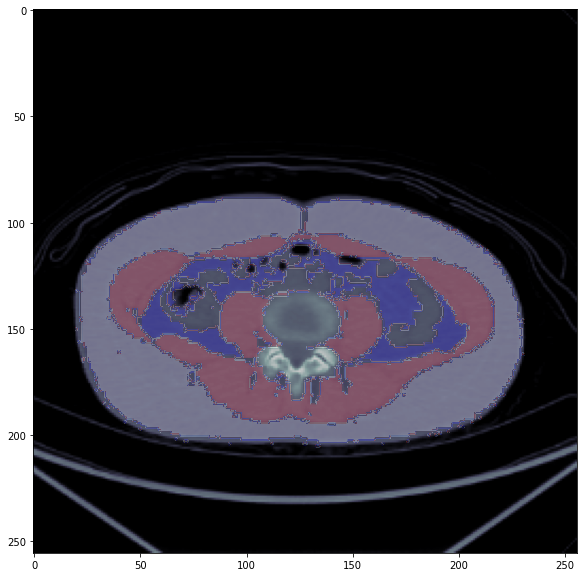

In [23]:
# 예시 확인
img_id = 45

CLASSES = 4
df = train_meta
cts_path = df['original'].tolist()
masks_path = df['part'].tolist()
dataset = CT_Dataset(train_meta, augmentation = get_training_augmentation(),  classes=CLASSES)


image, target = dataset[img_id]
print(image.shape)
print(target.shape)


plt.figure(figsize=(10,10))
img, mask = dataset[img_id]
plt.imshow(img[0,:,:], cmap='bone') # 원본 # permute는 축 변경
plt.imshow(mask.transpose([1,2,0]).argmax(axis = 2), alpha=0.2, cmap='flag') # 레이블
plt.show()

In [10]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = 'softmax'

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels = 1,
    classes=CLASSES, 
    activation = ACTIVATION
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [28]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = CT_Dataset(
    train_meta,
    augmentation=get_training_augmentation(), 
    preprocessing=None, #get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = CT_Dataset(
    test_meta,
    augmentation = None,
    preprocessing= None, #get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, persistent_workers = True)
valid_loader = DataLoader(valid_dataset,  batch_size=40, shuffle=False, num_workers=2)
loaders = {
    "train": train_loader,
    "valid": valid_loader
}

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2247: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [30]:
num_epochs = 100
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])

scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = smp.utils.losses.DiceLoss(eps=1.)
runner = SupervisedRunner(device=device)


In [31]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[DiceCallback(),
               JaccardCallback(),
               #EarlyStoppingCallback(patience=5, min_delta=0.001),
               ],
    # logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

1/100 * Epoch (train):   0% 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



1/100 * Epoch (train): 100% 13/13 [00:41<00:00,  3.19s/it, dice=0.390, iou=0.242, loss=0.454]
1/100 * Epoch (valid): 100% 2/2 [00:09<00:00,  4.82s/it, dice=0.334, iou=0.200, loss=0.835]
[2020-11-15 01:28:17,977] 
1/100 * Epoch 1 (_base): lr=0.0100 | momentum=0.9000
1/100 * Epoch 1 (train): dice=0.3753 | iou=0.2311 | loss=0.5520
1/100 * Epoch 1 (valid): dice=0.3337 | iou=0.2002 | loss=0.8346
2/100 * Epoch (train): 100% 13/13 [00:41<00:00,  3.19s/it, dice=0.400, iou=0.250, loss=0.378]
2/100 * Epoch (valid): 100% 2/2 [00:09<00:00,  4.79s/it, dice=0.398, iou=0.248, loss=0.396]
[2020-11-15 01:29:09,055] 
2/100 * Epoch 2 (_base): lr=0.0100 | momentum=0.9000
2/100 * Epoch 2 (train): dice=0.3944 | iou=0.2456 | loss=0.4194
2/100 * Epoch 2 (valid): dice=0.3976 | iou=0.2481 | loss=0.3963
3/100 * Epoch (train): 100% 13/13 [00:41<00:00,  3.16s/it, dice=0.407, iou=0.256, loss=0.329]
3/100 * Epoch (valid): 100% 2/2 [00:09<00:00,  4.78s/it, dice=0.408, iou=0.256, loss=0.323]
[2020-11-15 01:29:59,766] 

## train result visulization

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



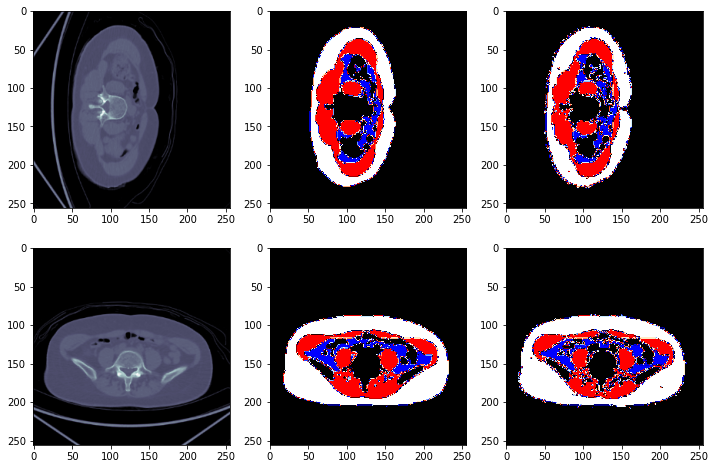

In [32]:
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
for i, train_batch in enumerate(loaders['train']):
    train_sample, train_mask = train_batch
    train_out = runner.predict_batch({"features": train_sample.cuda()})['logits']
    plt.subplot(2,3,1)
    # 원본과 레이블 겹쳐보기
    plt.imshow(train_sample[0].permute(1,2,0).numpy()[:,:,0],
               cmap='bone') # 원본 # permute는 축 변경
    #plt.imshow(train_out[0].permute(1,2,0).cpu().numpy().argmax(axis = 2),
    #           alpha=0.1, cmap='flag') # 레이블
    # 레이블만 다시 보기           
    plt.subplot(2,3,2)
    plt.imshow(train_out[0].permute(1,2,0).cpu().numpy().argmax(axis = 2),
               cmap='flag') # 레이블
    plt.subplot(2,3,3)
    plt.imshow(train_mask[0].permute(1,2,0).cpu().numpy().argmax(axis = 2),
                cmap='flag') # 레이블
    break
    

for i, test_batch in enumerate(loaders['valid']):
    test_sample, test_mask = test_batch
    test_out = runner.predict_batch({"features": test_sample.cuda()})['logits']
    plt.subplot(2,3,4)
    # 원본과 레이블 겹쳐보기
    plt.imshow(test_sample[0].permute(1,2,0).numpy()[:,:,0],
               cmap='bone') # 원본 # permute는 축 변경
    #plt.imshow(test_out[0].permute(1,2,0).cpu().numpy().argmax(axis = 2),
    #           alpha=0.1, cmap='flag') # 레이블
    # 레이블만 다시 보기           
    plt.subplot(2,3,5)
    plt.imshow(test_out[0].permute(1,2,0).cpu().numpy().argmax(axis = 2),
               cmap='flag') # 레이블
    plt.subplot(2,3,6)
    plt.imshow(test_mask[0].permute(1,2,0).cpu().numpy().argmax(axis = 2),
               cmap='flag') # 레이블
    break
plt.show()

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):
        BCE = nn.BCELoss()(inputs, targets)
        num = targets.size(0)     
        inputs = inputs.reshape(num, -1)
        targets = targets.reshape(num, -1)
        intersection = (inputs * targets).sum(1) 
        
        dice = (2.*intersection + smooth)/(inputs.sum(1) + targets.sum(1) + smooth) 
        dice_loss = 1 - dice.sum()/num
 
        loss_final = 3*BCE + dice_loss
        return loss_final
    
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU * 100
 
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()
    def forward(self, inputs, targets, smooth=1):
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score
    
 
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = 1
        self.gamma = 2
        
    def forward(self, inputs, targets):
        num = targets.size(0)
        inputs = inputs.reshape(num, -1)
        targets = targets.reshape(num, -1)
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        batch_loss = self.alpha * (1 - inputs) ** self.gamma * BCE_loss
        loss = batch_loss.mean()
        
        return loss
 
def compute_iou(model, loader, threshold=0.3):
    model.eval()
    valloss = 0
    
    with torch.no_grad():
        for data, target in loader:
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
 
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            print(out_cut.shape)
            print(target.data.shape)
            return
 
            picloss = DiceScore()(out_cut, target.data.cpu().numpy())
            valloss += picloss
 
    return valloss /len(loader)
 

In [ ]:
compute_iou(runner.model, train_loader)

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



(16, 4, 256, 256)
torch.Size([16, 4, 256, 256])
